<a href="https://colab.research.google.com/github/yashsolanki162003/Email_Spam_Detection_using_BERT/blob/main/Email_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

,count
Category,
ham,4825
spam,747


In [5]:
747/4825

0.15481865284974095

## 15% spam emails, 85% ham emails: This indicates class imbalance

In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

,count
Category,
ham,747
spam,747


In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5090,ham,"St andre, virgil's cream",0
955,spam,Filthy stories and GIRLS waiting for your,1
4622,ham,"Received, understood n acted upon!",0
2806,ham,I think it's all still in my car,0
4237,spam,U can WIN £100 of Music Gift Vouchers every we...,1


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [13]:
X_train.head(4)

,Message
4789,Thanx. Yup we coming back on sun. Finish dinne...
5280,"Vikky, come around &lt;TIME&gt; .."
5134,Sday only joined.so training we started today:)
3113,Just haven't decided where yet eh ?


## Now lets import BERT model and get embeding vectors for few sample statements

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [15]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.51327264, -0.88845706, ..., -0.7474882 ,
        -0.75314736,  0.919645  ],
       [-0.8720834 , -0.50543964, -0.9444667 , ..., -0.85847497,
        -0.7174535 ,  0.8808297 ]], dtype=float32)>

## Get embeding vectors for few sample words. Compare them using cosine similarity

In [16]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911087]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [18]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470379]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [19]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872033]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

In [32]:
!pip install -q keras-nlp

In [41]:
import tensorflow as tf
import keras_nlp

# Mixed precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

bert = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes=1,
    activation="sigmoid",
    max_sequence_length=128
)

# Freeze encoder
bert.backbone.trainable = False

In [42]:
bert.summary()

Preprocessor: "bert_text_classifier_preprocessor_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,009 (417.64 MB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 109,482,240 (417.64 MB)

In [43]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

bert.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [44]:
bert.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 326ms/step - accuracy: 0.6523 - loss: 0.6504 - precision: 0.5967 - recall: 0.5056
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.7746 - loss: 0.5359 - precision: 0.7748 - recall: 0.7591
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.8589 - loss: 0.4579 - precision: 0.8360 - recall: 0.8803
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.8614 - loss: 0.4136 - precision: 0.8306 - recall: 0.8977
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.8655 - loss: 0.3851 - precision: 0.8445 - recall: 0.8820
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.8791 - loss: 0.3773 - precision: 0.8549 - recall: 0.9020
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - accuracy: 0.8802 - loss: 0.3433 - precision: 0.8570 - recall: 0.9000
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.8764 - loss: 0.3340 - precision: 0.8546 - recall: 0.8940
Epoch 9/

In [45]:
bert.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step - accuracy: 0.9454 - loss: 0.2288 - precision: 0.9261 - recall: 0.9626


[0.22679403424263, 0.9518716335296631, 0.9378238320350647, 0.9679144620895386]

In [46]:
y_predicted = bert.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 574ms/step


In [47]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[175,  12],
       [  6, 181]])

Text(50.722222222222214, 0.5, 'Truth')

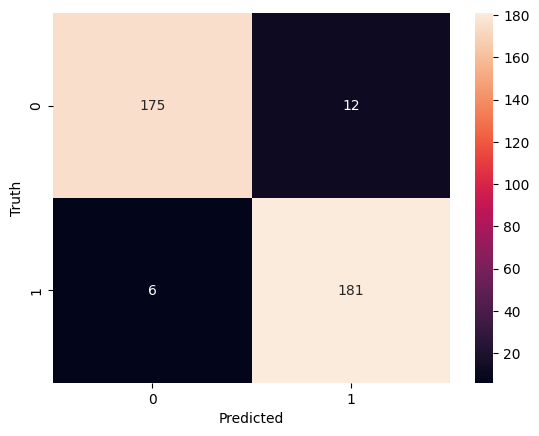

In [49]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       187
           1       0.94      0.97      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



In [51]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
bert.predict(reviews)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.7817],
       [0.8364],
       [0.788 ],
       [0.2576],
       [0.1417]], dtype=float16)